In [86]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [87]:
NUM_TRADING_DAYS = 252
NUM_PORTFOLIOS = 10000

stocks = ['AMD','NVDA','GM']

start_date = '2017-01-01'
end_date = '2023-01-01'

In [88]:
stock_data = {}

for stock in stocks: 
    ticker = yf.Ticker(stock)
    stock_data[stock] = ticker.history(ticker,start=start_date,end=end_date)['Close']

stock_data = pd.DataFrame(stock_data)
stock_data.head()

# Iterating over the list of stocks and appending their historic prices to a pandas dataframe

,AMD,NVDA,GM
Date,,,
2017-01-03 00:00:00-05:00,11.43,25.138275,30.369267
2017-01-04 00:00:00-05:00,11.43,25.724783,32.045403
2017-01-05 00:00:00-05:00,11.24,25.071741,31.440607
2017-01-06 00:00:00-05:00,11.32,25.406889,31.095016
2017-01-09 00:00:00-05:00,11.49,26.436960,31.112291


In [89]:
def calculate_return(data):
    log_return = np.log(data/data.shift(1))
    return pd.DataFrame(log_return[1:])

log_returns = pd.DataFrame(calculate_return(stock_data))

# We use log returns for that standardizing effect and reducing the effect of outliers 

In [90]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        # Dividing all of the weight by the sum so that it always adds up to a total of 1 (100% of the portfolio).

        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()  * NUM_TRADING_DAYS, w))))

        # Here we are only measuring the returns, weights, and volatility 
        # of the generated portfolios and appending them to lists
        # which are returned as arrays from the function. Volatility is measured as standard deviation.

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [91]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean()*weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return,portfolio_volatility, portfolio_return/portfolio_volatility])

# Here I am calculating statistics that will be used in creating constraints used.

def min_function_sharpe(weights,returns):
    return -statistics(weights,returns)[2]

In [92]:
def optimize_portfolio(weights,returns):
    # The constraing is that the sum of the weights is equal to 1
    constraints = {'type':'eq','fun':lambda x: np.sum(x) - 1}
    # The weights of each stock can also be 1 at most. 
    # Which would imply 100% of money is invested into 1 single stock
    bounds = tuple((0.15,1) for _ in range(len(stocks)))

    return minimize(fun=min_function_sharpe, x0=weights[0],args=returns,method='SLSQP',bounds=bounds,constraints=constraints)
# I definitely need more experience using scipy. There are likely other ways to 
# manipulate bounds and constraints such as finding the maximum maximum 
# returns given a certain amount of volatility, 
# or minimum volatility given a certain amount of returns. 

In [93]:
pweights, means, risks = generate_portfolios(log_returns)
optimum = optimize_portfolio(pweights,log_returns)

In [94]:
def print_optimal_portfolio(optimum,returns):
    print('Optimal portfolio:',optimum['x'].round(3))
    print('Expected Return, Volatility, and Sharpe Ratio Respectively:',statistics(optimum['x'].round(3),returns))

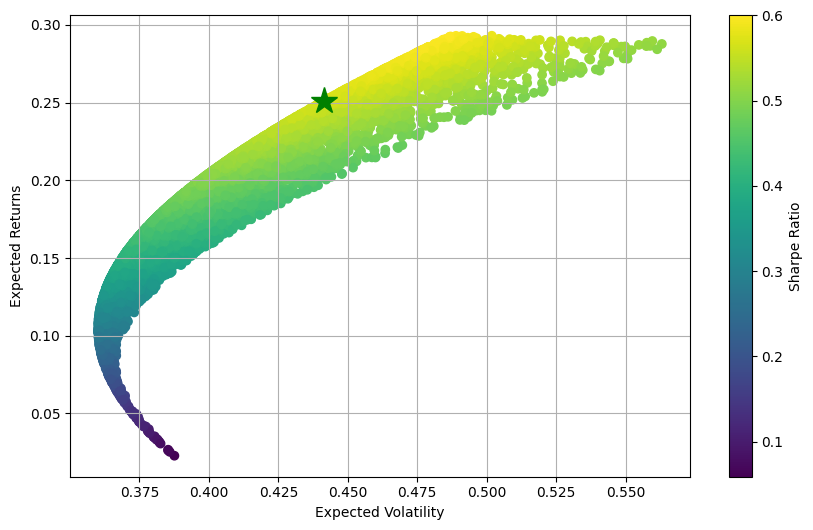

Optimal portfolio: [0.241 0.609 0.15 ]
Expected Return, Volatility, and Sharpe Ratio Respectively: [0.25115491 0.44155316 0.56879881]


In [95]:
def show_optimal_portfolios(opt,rets,portfolio_rets,portfolio_vols):
    plt.figure(figsize=(10,6))
    plt.scatter(portfolio_vols,portfolio_rets,c=portfolio_rets/portfolio_vols,marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label='Sharpe Ratio')

    plt.plot(statistics(opt['x'],rets)[1],statistics(opt['x'],rets)[0],'g*',markersize=20)

    plt.show()

show_optimal_portfolios(optimum,log_returns,means,risks)
print_optimal_portfolio(optimum,log_returns)

# The weights are printed in the order that the stocks are given. The portfolio represented by the star
# is the maximum Sharpe Ratio within the bounds of each holding representing between 15% and 100%.